## N차 과제 - Time Series Analysis_주가예측

- 주제: 시계열 모델을 주가 데이터에 대한 시계열 예측 및 분석
- 데이터: 주식 데이터(크롤링 or 라이브러리로 데이터 불러오기)
- 사용 라이브러리: yfinance, datareader, statsmodels, matplotlib etc.

In [3]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

### 1. EDA 및 전처리

1.1 분석을 위해 사용할 특정 주식(1개)의 데이터를 불러오거나 크롤링하여 가져오세요(**최소 3년 이상의 데이터 추출 권고**).

In [12]:
df = yf.download('XOM',start = '2020-01-01',end='2024-10-01')
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,70.239998,71.019997,70.239998,70.900002,56.088306,12456400
2020-01-03,71.339996,71.370003,70.160004,70.330002,55.637363,17386900
2020-01-06,70.320000,71.360001,70.230003,70.870003,56.064568,20081900
2020-01-07,70.500000,70.519997,69.510002,70.290001,55.605728,17387700
2020-01-08,70.110001,70.290001,69.169998,69.230003,54.767185,15137700


1.2 결측치가 있는지 확인하고 있다면 제거해주세요.

In [13]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

1.3 일자를 인덱스로 설정하고 시간 순서대로 정렬하세요.

In [14]:
df.sort_index(inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,70.239998,71.019997,70.239998,70.900002,56.088306,12456400
2020-01-03,71.339996,71.370003,70.160004,70.330002,55.637363,17386900
2020-01-06,70.320000,71.360001,70.230003,70.870003,56.064568,20081900
2020-01-07,70.500000,70.519997,69.510002,70.290001,55.605728,17387700
2020-01-08,70.110001,70.290001,69.169998,69.230003,54.767185,15137700


1.4 수정종가(adj close)와 거래량(volume)을 시각화하세요.

##### 수정 종가
- 회사의 배당, 주식 분할, 배당금 지급, 주식 배당과 같은 기업 활동을 반영한 주식의 종가
- 주가가 분할되거나 배당금이 지급되면 주가에 큰 변동이 생김 -> 투자자들이 실제 주식의 가격 변동을 정확하게 파악하기 위해 수정 종가 사용 

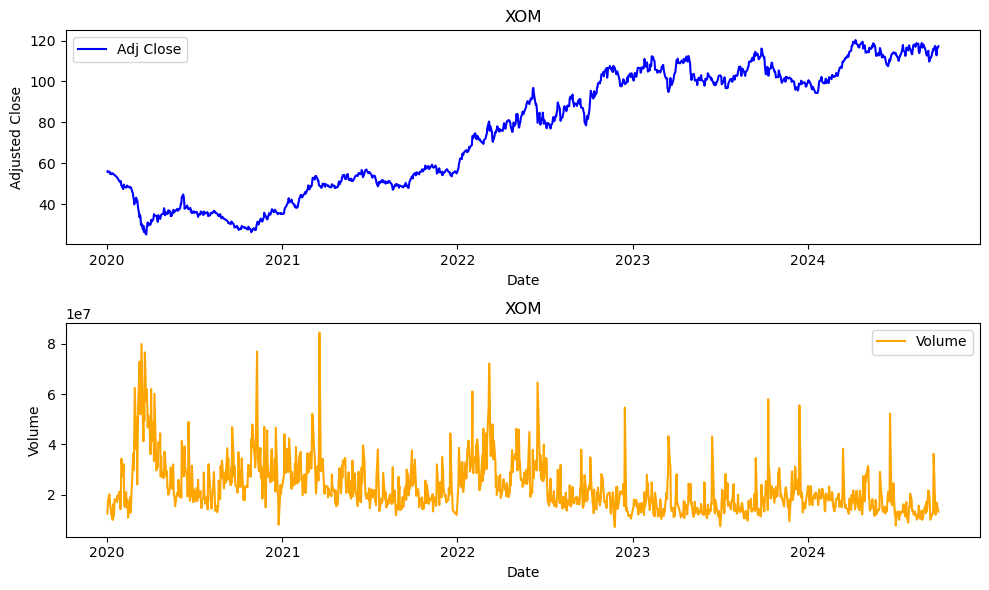

In [20]:
plt.figure(figsize=(10,6))

plt.subplot(2, 1, 1)
plt.plot(df['Adj Close'], label='Adj Close', color='blue')
plt.title('XOM')
plt.xlabel('Date')
plt.ylabel('Adjusted Close')
plt.legend()

# 거래량 시각화
plt.subplot(2, 1, 2)
plt.plot(df['Volume'], label='Volume', color='orange')
plt.title('XOM')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()

# 그래프 표시
plt.tight_layout()
plt.show()

1.5 위 시각화 과정을 통해 알 수 있는 내용에 대해 작성하세요.

- 2020년 하락세를 보이다가 2021년 이후 2024년까지 상승세를 지속하고 있음
- 2022년과 2023년 사이에 급격한 상승이 있었고, 그 이후로는 안정적인 수준을 보임 
- 거래량은 시간에 따른 변동이 크다, 2020년과 2021년에 거래량이 높음
- 특정 시점에서 급격한 거래량 증가가 관찰됨 

### 2. 추세 및 정상성 검정

2.1 시계열 데이터의 정상성을 검증하도록 하겠습니다. 시계열 데이터 말하는 정상성(stationarity)이 무엇인지 왜 해야 하며 비정상성의 해결 방법에는 무엇이 있는지 작성하세요.

##### 정상성 : 시간에 관계 없이 데이터의 통계적 성질이 일정한 것 
##### 정상성 만족 요건 3가지
- 평균이 일정
    : 데이터의 평균이 시간과 관계 없이 일정함
- 분산이 일정
    : 데이터의 분산도 시간과 관계 없이 일정함
- 자기공분산이 일정 
    : 데이터의 시차에 따른 자기공분산도 시간과 관계 없이 일정함 

=> 정상성을 가지지 않는 데이터를 바로 모델링할 경우, 예측 결과의 신뢰성이 떨어질 수 있음 

###### 해결 방법 
1. 차분
    - 일반 차분
    - 계절 차분 
2. 변환 
    - 로그 변환
    - Box-Cox 변환 
        

2.2 먼저 ADF Test를 수행하겠습니다. statsmodels의 adfuller 라이브러리를 import 한 후 수정 종가에 대한 검정을 수행하고 결과를 출력하세요(p-value 포함).

ADF Test란? - https://hongl.tistory.com/98

In [22]:
adf = adfuller(df['Adj Close'])
print('ADF Statistic: %f' % adf[0])
print('p-value: %f' % adf[1])

ADF Statistic: -0.371442
p-value: 0.914759


2.3 ADF Test 결과를 해석하세요.

- P-value가 0.91로 수정 종가 데이터가 비정상적임 ( 귀무가설 : 데이터는 비정상적이다 기각 불가 ) 
    - 평균과 분산이 시간에 관계 없이 일정하지 못함 

2.4 ACF 그래프와 PACF 그래프를 그려보도록 하겠습니다. 먼저 ACF와 PACF 각각이 어떻게 다른지 설명하세요.

##### ACF : 자기상관 함수 
- 시차에 따른 자기상관
- 현재 데이터가 과거 데이터와 어느정도 연관이 있는지 보여줌 
- 추세나 계절성을 판단하는데 이용

##### PACF : 부분 자기상관함수
- 특정 시차에 대한 상관성
- 중간 시차의 영향을 없앰
- 특정 시차에서 직접적인 상관관계를 확인하는데 유용 

2.5 statsmodels의 plot_acf, plot_pacf 라이브러리를 import하고 Adj close값에 대한 ACF, PACF 그래프를 출력하세요.

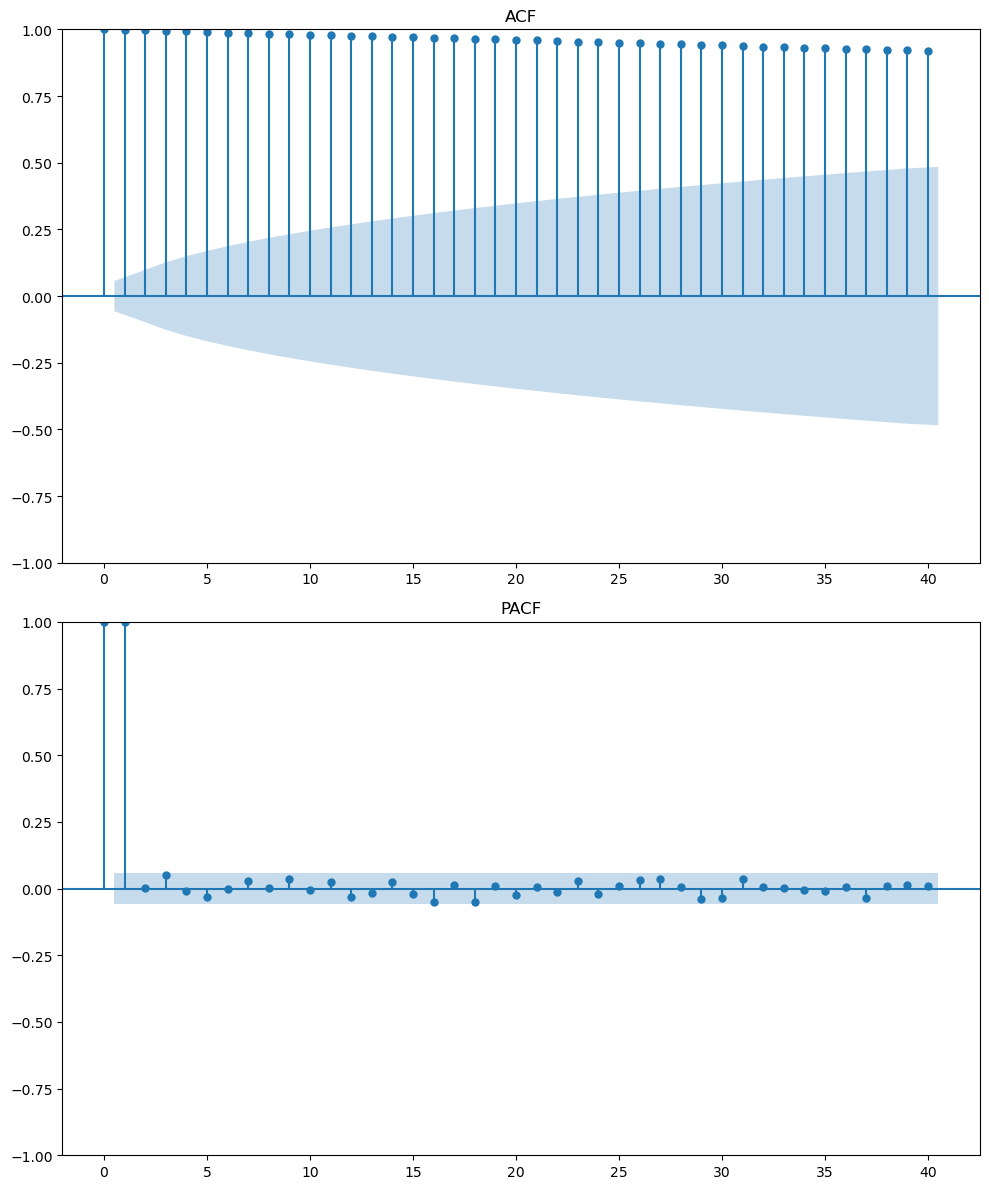

In [25]:
plt.figure(figsize=(10, 12))

plt.subplot(2, 1, 1)
plot_acf(df['Adj Close'], ax=plt.gca(), lags=40)
plt.title('ACF')

plt.subplot(2, 1, 2)
plot_pacf(df['Adj Close'], ax=plt.gca(), lags=40)
plt.title('PACF')

plt.tight_layout()
plt.show()

2.6 결과를 해석하세요.

- ACF 그래프가 여러 시차에서 강한 상관성을 보임 => 데이터 비정상
- ACF 감소가 완만 => 추세 OR 계절성 존재
- PACF : 1차에서 급격히 감소, AR(1) 모델 적합할 것으로 예상

2.7 마지막으로 계절성이 있는지 여부를 확인하겠습니다. statsmodels의 seasonal_decompose 라이브러리를 import하고 plot을 출력하세요.

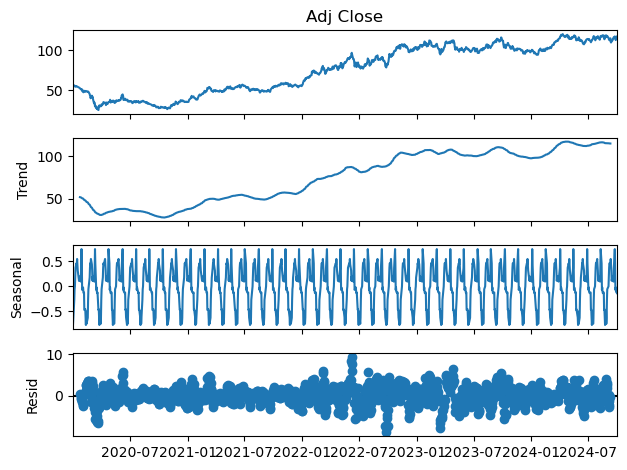

In [29]:
seasonal = seasonal_decompose(df['Adj Close'], model='additive', period=30)
seasonal.plot()
plt.show()

2.8 위 결과를 해석하세요.

- adj close 
    : 주식 가격이 전반적으로 상승하는 추세
- trend 
    : 2021년 후반부터 뚜렷한 상승세
    : 장기적인 가격 상승 존재
- Seasonal 
    : 주기적인 패턴 반복
- residual 
    : 추세나 계절성 외에 설명되지 않는 변동 존재 ( 일부 구간에서 큰 변동 존재 ) 

2.9 위에서 진행한 검정 과정 및 시각화 결과를 종합해봤을 때 현 데이터는 비정상성임을 알 수 있습니다. 따라서 차분을 통해 이를 해결하도록 하겠습니다. 먼저 차분이 어떤 것인지에 대해 설명하세요.

- 비정상 시계열을 정상 시계열로 변환하는 방법
- 현재 값에서 이전 값을 뺀다
- 평균과 분산이 시간에 따라 변하지 않게 만들어 정상 시계열로 변환

2.10 1차 차분을 진행하도록 하겠습니다. diff() 함수를 활용해 1차 차분을 진행한 후 ADF Test를 수행하여 정상성 여부를 확인하세요.

In [30]:
df['Adj Close Diff'] = df['Adj Close'].diff()
adf_result = adfuller(df['Adj Close Diff'].dropna())
adf_statistic = adf_result[0]
p_value = adf_result[1]
print('ADF Statistic:', adf_statistic)
print('p-value:', p_value)

ADF Statistic: -25.278661229070295
p-value: 0.0


2.11 추가로 위에서 그려보았던 plot들을 다시 그려보면서 비교를 통해 정상성 여부를 확인해보도록 하겠습니다. ACF PACF plot, 계절성 분해 plot을 그려보세요.

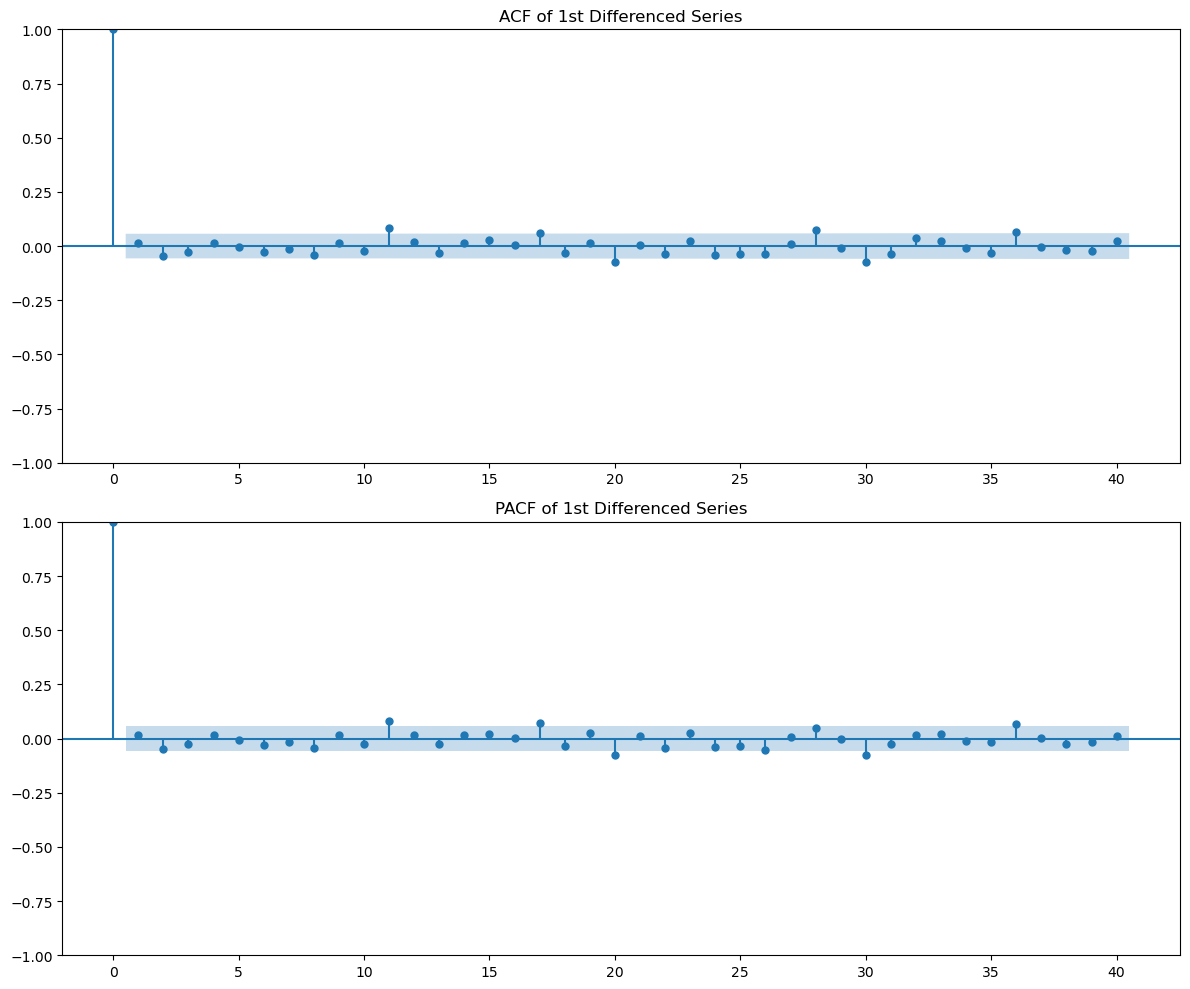

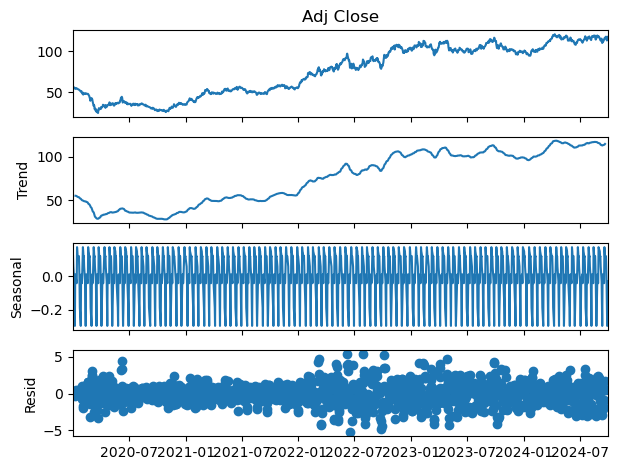

In [31]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
plot_acf(df['Adj Close Diff'].dropna(), ax=plt.gca(), lags=40)
plt.title('ACF of 1st Differenced Series')

plt.subplot(2, 1, 2)
plot_pacf(df['Adj Close Diff'].dropna(), ax=plt.gca(), lags=40)
plt.title('PACF of 1st Differenced Series')

plt.tight_layout()
plt.show()

result = seasonal_decompose(df['Adj Close'], model='additive', period=12)  # period를 적절히 설정
result.plot()
plt.show()

### 3. 예측

3.1 데이터의 정상성을 확인했으니 본격적으로 예측 및 분석을 진행해보도록 하겠습니다.

아래 코드는 예시이므로 예시에서 사용된 모델이 아닌 다른 모델(ex. ARIMAX, ARCH/GARCH, LSTM, Transformer, DLinear etc.)를 사용하고 애플이 아닌 다른 주식을 사용해 예측 및 분석을 진행해주세요(**위에서 진행한 과정 역시 모두 예시이므로 새로운 주식에 대한 전처리 및 정상성 검정을 새로 진행해야 함**).

In [49]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

In [50]:
df['Adj Close Diff']

Date
2020-01-02         NaN
2020-01-03   -0.450943
2020-01-06    0.427204
2020-01-07   -0.458839
2020-01-08   -0.838543
                ...   
2024-09-24   -0.309998
2024-09-25   -2.280006
2024-09-26   -1.969994
2024-09-27    3.019997
2024-09-30    1.400002
Name: Adj Close Diff, Length: 1194, dtype: float64

In [55]:
endog = df['Adj Close Diff'].dropna()
n_forecast = 30  

exog = np.random.rand(len(endog))
exog_df = pd.Series(exog, index=endog.index)  

model = SARIMAX(endog, exog=exog_df, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit()

forecast = results.get_forecast(steps=n_forecast, exog=np.random.rand(n_forecast))
forecast_index = pd.date_range(start=endog.index[-1] + pd.Timedelta(days=1), periods=n_forecast, freq='B')
forecast_series = forecast.predicted_mean

/Users/nawon/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nawon/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.99844D+00    |proj g|=  1.89237D-01

At iterate    5    f=  1.82420D+00    |proj g|=  1.27699D-01

At iterate   10    f=  1.79081D+00    |proj g|=  2.08832D-03

At iterate   15    f=  1.78749D+00    |proj g|=  1.72786D-03

At iterate   20    f=  1.78738D+00    |proj g|=  1.55598D-04

At iterate   25    f=  1.78738D+00    |proj g|=  4.14979D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     31      1     0     0   

/Users/nawon/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nawon/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


/Users/nawon/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nawon/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


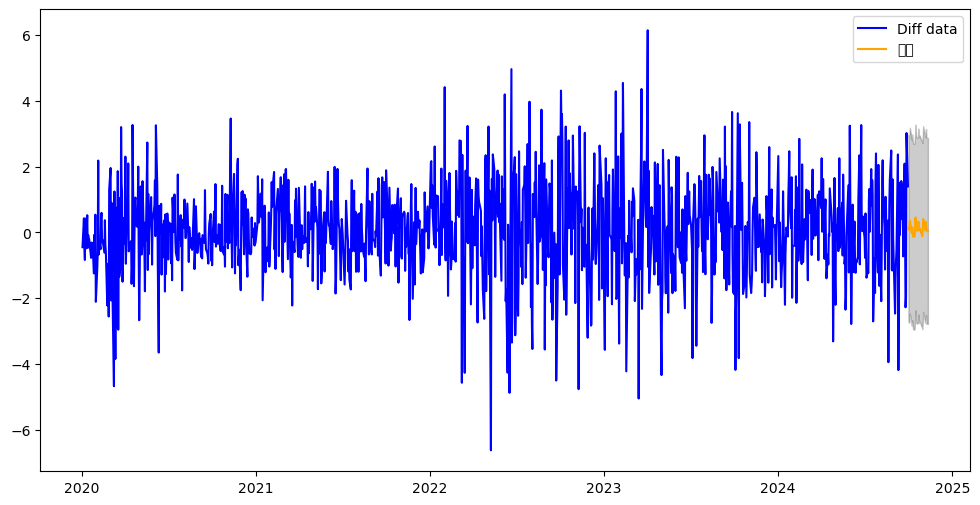

In [57]:
# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(endog.index, endog, label='Diff data', color='blue')
plt.plot(forecast_index, forecast_series, label='예측', color='orange')
plt.fill_between(forecast_index, 
                 forecast.conf_int()['lower Adj Close Diff'], 
                 forecast.conf_int()['upper Adj Close Diff'], 
                 color='k', alpha=0.2)
plt.legend()
plt.show()